## 1.환경준비

### (1) 라이브러리 로딩

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from keras.models import Sequential
from tensorflow.keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam

import mlflow
import mlflow.keras

In [40]:
np.set_printoptions(linewidth=np.inf)

* 함수 만들기

In [41]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

In [42]:
path = 'data/'
file = 'sign_language.csv'

data = pd.read_csv(path+file)
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,22,186,186,185,185,185,184,185,184,184,...,171,122,65,62,215,180,99,47,31,25
1,24,175,177,179,181,181,182,182,182,183,...,202,202,201,200,199,197,195,193,191,189
2,6,187,187,187,187,187,186,187,186,186,...,45,23,25,34,41,43,39,40,43,35
3,2,169,169,169,170,169,170,169,169,169,...,204,203,200,199,198,196,194,193,191,190
4,21,153,165,170,179,190,198,203,206,213,...,161,122,132,96,75,63,37,43,70,66


In [44]:
import string
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)
len(class_names), class_names

(26,
 array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1'))

### (3) mlflow 추적 준비
* 서버 주소 사용

In [45]:
mlflow_uri = "http://mlflow.carpediem.so/"
mlflow.set_tracking_uri(mlflow_uri)

### (4) 새 실험 생성
실험 아이디 17

In [46]:
exp_id = '17'

## 2.데이터 준비

### (1) 데이터 분할1 : x, y 나누기

In [47]:
x = data.drop(['label'], axis=1)
y = data.loc[:, 'label']

### (2) 데이터 분할2 : train, test

* 적절하게 분할 하시오.

In [48]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1000, stratify=y)
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=2000, stratify=y_train)
print(x_tr.shape, x_val.shape, x_test.shape)

(5000, 784) (2000, 784) (1000, 784)


c:\Users\user\anaconda3\envs\ml_pipeline\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\user\anaconda3\envs\ml_pipeline\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\user\anaconda3\envs\ml_pipeline\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\user\anaconda3\envs\ml_pipeline\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype

### (3) DL을 위한 전처리
* 모두 넘파이로 변환

In [49]:
x_tr = x_tr.values
y_tr = y_tr.values
x_val = x_val.values
y_val = y_val.values
x_test = x_test.values
y_test = y_test.values

* shape 맞추기 n, 28,28,1

In [50]:
x_tr = x_tr.reshape(-1, 28, 28, 1) 
x_val = x_val.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

* Scaling : Min-Max
    * 0-255 값으로 되어 있는 데이터를 0-1사이 값으로 변환
    * x_train2, x_val2 를 그냥 255로 나누면 됨

In [51]:
x_tr = x_tr/255
x_val = x_val/255
x_test = x_test/255

## 3.모델링
* 개인별 모델링 및 추적

### (1) 모델 추적

In [30]:
with mlflow.start_run(experiment_id=exp_id, run_name = 'seyeon01'):
    
    # autolog 시작!
    mlflow.keras.autolog()    
    
    ## Functional API
    # 1. 세션 클리어 : 메모리에 모델 구조가 남아있으면 지워줘.
    clear_session()

    # 2. 레이어 엮기 : 사슬처럼!
    il = Input(shape=(28,28,1))

    hl = Conv2D(filters=128,       # 새롭게 제작하려는 feature map의 수!
                kernel_size=(3,3), # Convolutional Filter의 가로세로 사이즈!
                strides=(1,1),     # Convolutional Filter의 이동 보폭!
                padding='same',    # 패딩 적용 유무!
                activation='relu'  # 활성화 함수 반드시!
                )(il)
    hl = Conv2D(filters=128,       # 새롭게 제작하려는 feature map의 수!
                kernel_size=(3,3), # Convolutional Filter의 가로세로 사이즈!
                strides=(1,1),     # Convolutional Filter의 이동 보폭!
                padding='same',    # 패딩 적용 유무!
                activation='relu'  # 활성화 함수 반드시!
                )(hl)
    hl = MaxPool2D(pool_size=(2,2), # Pooling Filter의 가로세로 크기
                strides=(2,2)    # Pooling Filter의 이동 보폭! (None은 기본적으로 pool_size를 따라감)
                )(hl)
    hl = Dropout(0.2)(hl)

    hl = Conv2D(filters=64,       # 새롭게 제작하려는 feature map의 수!
                kernel_size=(3,3), # Convolutional Filter의 가로세로 사이즈!
                strides=(1,1),     # Convolutional Filter의 이동 보폭!
                padding='same',    # 패딩 적용 유무!
                activation='relu'  # 활성화 함수 반드시!
                )(hl)
    hl = Conv2D(filters=64,       # 새롭게 제작하려는 feature map의 수!
                kernel_size=(3,3), # Convolutional Filter의 가로세로 사이즈!
                strides=(1,1),     # Convolutional Filter의 이동 보폭!
                padding='same',    # 패딩 적용 유무!
                activation='relu'  # 활성화 함수 반드시!
                )(hl)
    hl = MaxPool2D(pool_size=(2,2), # Pooling Filter의 가로세로 크기
                strides=(2,2)    # Pooling Filter의 이동 보폭! (None은 기본적으로 pool_size를 따라감)
                )(hl)
    hl = Dropout(0.2)(hl)

    hl = Flatten()(hl)
    hl = Dense(128, activation='relu')(hl)
    ol = Dense(26, activation='softmax')(hl)

    # 3. 모델의 시작과 끝 지정
    model = Model(il, ol)

    # 4. 컴파일
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
                )

    model.summary()

    from tensorflow.keras.callbacks import EarlyStopping

    es = EarlyStopping(monitor='val_loss',       # 얼리스토핑 적용할 관측 대상
                    min_delta=0,              # Threshold. 설정한 값 이상으로 변화해야 개선되었다 간주.
                    patience=3,               # 성능 개선이 발생하지 않을 때, 몇 Epochs 더 볼 것인지.
                    verbose=1,
                    restore_best_weights=True # 가장 성능이 좋게 나온 Epoch의 가중치로 되돌림
                    )

    hist = model.fit(x_tr, y_tr, epochs=10, verbose=1,
                    validation_split=0.2,
                    callbacks=[es]
                    )
    
    # 수동등록 : 모델 기록하기
    mlflow.keras.log_model(model, "model", registered_model_name="Sign_Signal_17") 
    
    # autolog 종료
    mlflow.keras.autolog(disable = True)



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        73792     
                                                             

INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp28d8p17s\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp28d8p17s\model\data\model\assets
2023/12/04 15:42:04 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpg85sws9a\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpg85sws9a\model\data\model\assets
Successfully registered model 'Sign_Signal_17'.
2023/12/04 15:42:14 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Sign_Signal_17, version 1
Created version '1' of model 'Sign_Signal_17'.


* 학습곡선

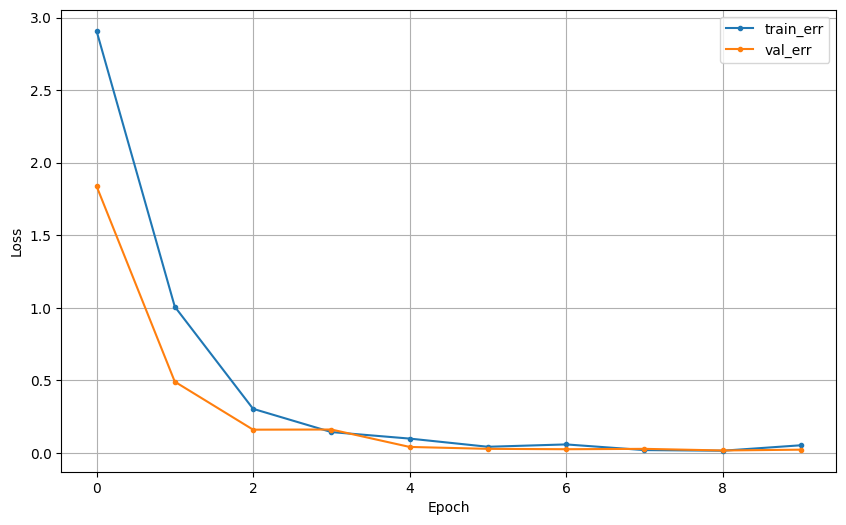

In [31]:
dl_history_plot(hist.history)

* 예측 및 검증

In [32]:
pred = model.predict(x_val)
pred_1 = pred.argmax(axis=1)
print(accuracy_score(y_val,pred_1))
print('-'*60)
print(confusion_matrix(y_val, pred_1))

63/63 [==============================] - 2s 34ms/step
0.996
------------------------------------------------------------
[[84  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 77  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 79  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 85  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 68  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 89  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 85  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 77  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 81  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 85  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  1  0  0 88  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 83  0  0  0  0  0  

In [33]:
print(classification_report(class_names[y_val], class_names[pred_1]))

              precision    recall  f1-score   support

           a       1.00      1.00      1.00        84
           b       1.00      1.00      1.00        77
           c       0.96      1.00      0.98        79
           d       1.00      1.00      1.00        85
           e       0.99      1.00      0.99        68
           f       1.00      1.00      1.00        89
           g       1.00      0.99      0.99        86
           h       0.97      1.00      0.99        77
           i       1.00      0.98      0.99        83
           k       1.00      1.00      1.00        85
           l       1.00      0.98      0.99        90
           m       1.00      1.00      1.00        83
           n       1.00      1.00      1.00        85
           o       1.00      0.98      0.99        85
           p       0.97      1.00      0.99        73
           q       1.00      1.00      1.00        95
           r       1.00      1.00      1.00        91
           s       1.00    

## 4.모델 사용하기

### (1) 운영모델 로딩

In [52]:
# model_uri = "models:/model_14/production" 
# model_p = mlflow.keras.load_model(model_uri)

# 운영중인 버전 가져오기
model_uri = "models:/Sign_Signal_17/production" 
model_p = mlflow.keras.load_model(model_uri)

### (2) test 데이터로 예측하고 평가

In [53]:
pred = model_p.predict(x_test)
pred_1 = pred.argmax(axis=1)

32/32 [==============================] - 1s 33ms/step


In [54]:
print(accuracy_score(y_test, pred_1))
print('-'*60)
print(confusion_matrix(y_test, pred_1))
print('-'*60)
print(classification_report(class_names[y_test], class_names[pred_1]))

0.997
------------------------------------------------------------
[[42  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 34  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 40  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 42  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0 44  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 41  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  

### (2) 이미지 로딩해서 사용하기

In [55]:
# 파이프라인에서 필요한 라이브러리/함수
import pandas as pd
import numpy as np
import cv2
import joblib

In [56]:
# 파일 열기
path = 'test image/'
file = 'v.png'
filename = path + file
img = cv2.imread(filename , cv2.IMREAD_GRAYSCALE)

# 크기 조절하기
img = cv2.resize(img, (28, 28))

# 입력데이터 형식을 갖추기
test_sign = img.reshape(1,28,28,1)

test_sign = test_sign / 255.

pred = model_p.predict(test_sign)
pred_1 = pred.argmax(axis=1)
print(class_names[pred_1])

1/1 [==============================] - 0s 21ms/step
['v']
